# Toy Model

Trying toy model inspired by [Griffiths & Steyvers, 2004](https://doi.org/10.1073/pnas.0307752101).

In [58]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

np.random.seed(42)
tf.random.set_seed(42)

## **Sampling Behaviour of `tfp.Distributions`**

In [59]:
## tfd.Categorical sampling behaviour:
probs = tf.constant([[0., 0., 1.], 
                     [1., 0., 0.]])
print(probs.shape)
tfd.Categorical(probs=probs).sample(4).numpy()

(2, 3)


array([[2, 0],
       [2, 0],
       [2, 0],
       [2, 0]])

In [60]:
## tfd.Dirichlet sampling behavious:
conc = tf.constant([[0.1, 0.1, 0.1], 
                    [  2.,  2.,  2.]])
tfd.Dirichlet(conc).sample().numpy()

array([[0.02140409, 0.01427036, 0.9643255 ],
       [0.38862276, 0.16176145, 0.44961584]], dtype=float32)

$\rightarrow$ Samples come in by row. For Categorical the sample size is flexible. For Dirichlet the sample cise is bounded to the concentrations.

## **Setting up Topics and Data**

1. Specify global parameters

In [61]:
## Number of Topics
K = 10

## Square Root of the Number of "Vocabulary" (must be sqrt such that pictorial interpretation is possible)
sqrtV = 5

## Number of words per document
N = 100

## Number of documents
D = 1000

2. Define Topic-Word relations and priors

In [62]:
## Word grid
V = int(sqrtV**2)
V_grid = np.reshape(np.arange(0, V), newshape=(sqrtV, sqrtV))

## Topic-Word Distribution
#  Words belonging to a topic are rows and columns
Theta_idx = [row for row in V_grid] + [col for col in V_grid.T]
Theta = np.zeros((K, V))
for k, idx in enumerate(Theta_idx):
    Theta[k, idx] = 1. / sqrtV
Theta = tf.constant(Theta, dtype=tf.float32)

## Document topic prior
Alpha = 1

3. Generating Data

In [63]:
## Topic-Word Distibution is omitted because Theta is fixed

## Document-Topic Distribution
dist_Pi = tfd.Dirichlet(K*[Alpha])
Pi      = dist_Pi.sample(D)

## Topic Assignments of word c_{dik} of word w_{di}
dist_C    = tfd.Categorical(probs=Pi)
C         = tf.reshape(dist_C.sample(N), shape=(D, -1)) ## Its more efficient to reshape before converting to one_hot vectors
C_one_hot = tf.one_hot(C, depth=K, axis=-1)
assert tf.reduce_all(tf.reduce_sum(C_one_hot, axis=-1) == 1)

## Draw words w_{di}
dist_W = tfd.Categorical(tf.gather(Theta, C))
W = dist_W.sample()
W.shape

TensorShape([1000, 100])

In [64]:
tf.gather(Theta, C).shape

TensorShape([1000, 100, 25])

In [65]:
print(Pi.shape)
print(C.shape)
print(W.shape)

(1000, 10)
(1000, 100)
(1000, 100)


## Visualization

In [66]:
def format_to_img(arr, sqrtV=5):
    vals = dict(zip(*np.unique(arr, return_counts=True)))
    img = []

    for i in range(V):
        if i in vals:
            img.append(vals[i])
        else:
            img.append(0)

    img = np.array(img).reshape(sqrtV, sqrtV)

    return img

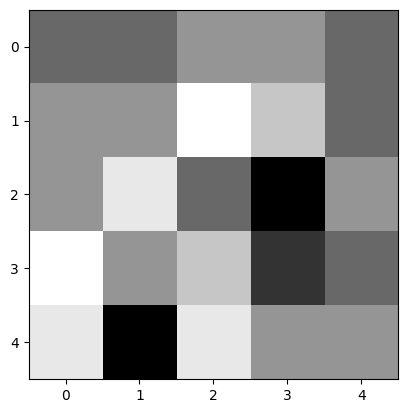

In [67]:
plt.imshow(format_to_img(W[100]), cmap="Greys")

## Gibbs Sampler

#### N-Tensor
One efficiency crtitical step is to vectorize 
$$
    n_{dkv} =  \{i \, \vert \, w_{di} == v \ \& \ c_{idk} ==1\}
$$
which can be realized by stacking $W$ $K$ times along the last axis to match the shape of $C$.

In [68]:
TEST_N_tensor = False

In [69]:
def n_tensor(W, C_one_hot, V=25):
    W = W.numpy()
    C_one_hot = C_one_hot.numpy()
    n = np.zeros(shape=(C_one_hot.shape[0], C_one_hot.shape[2], V))
    for v in range(V):
        # print(v)
        for i in range(C_one_hot.shape[1]):
            for d in range(C_one_hot.shape[0]):
                for k in range(C_one_hot.shape[2]):
                    if W[d, i] == v and C_one_hot[d, i, k] == 1:
                        n[d, k, v] += 1
    return n

@tf.function
def tf_N_tensor(W, C_one_hot, V=25):

    ## Extracting shapes
    D = C_one_hot.shape[0]
    N = C_one_hot.shape[1]
    K = C_one_hot.shape[2]
    
    ## Preparing W-stacking by shifting all entries one "up" s. t. v is counted 
    #  from 1 to 25 instead from 0 to 24. This enables to collapse the "&" in the
    #  set to be collapsed to a matrix product
    Wp1 = W + 1
    W_stacked = tf.stack(K*[Wp1], axis=-1)    

    ## Elementwise product combines logical & in condition.
    #  Choosing int32 as product dtype for efficiency.
    C_one_hot_int = tf.cast(C_one_hot, dtype=tf.int32)
    C_Dot_W = tf.math.multiply(W_stacked, C_one_hot_int)

    ## The v-dimension of N is a one-hot encoding for the vocabulary:
    N_DNKVp1 = tf.one_hot(C_Dot_W, 25+1, dtype=tf.int32)

    ## Reverting the v-shift by dropping the 0 one-hot dimension
    N_DNKV = N_DNKVp1[:, :, :, 1:]

    ## Summing along v-dimension
    assert N_DNKV.shape[1] == N
    N_DKV = tf.reduce_sum(N_DNKV, axis=1)

    ## Turn to float for gibbs sampler
    N_DKV = tf.cast(N_DKV, dtype=tf.float32)

    return N_DKV

In [70]:
if TEST_N_tensor:
    test1 = tf_N_tensor(tf.Variable(W), tf.Variable(C_one_hot))
    test2 = n_tensor(W, C_one_hot)
    assert list(test2.shape) == test1.shape.as_list()
    assert np.all(test1.numpy() == test1)

#### Sampling $C$

Sampling $\Theta$ and $\Pi$ is not very problematic because they are just dirichlet distributed (below). Sampling $C$ is sampling from 
$$
    p(C\vert \Theta, \Pi, W)=\prod_{d=1}^D \prod_{i=1}^N \frac{\prod_{k=1}^K \left(\pi_{dk}\theta_{kw_{di}}\right)^{c_{dik}}}{\sum_{k'=1}^K\left(\pi_{dk'}\theta_{k'w_{di}}\right)}
$$ 
which is a categorical distribution.

https://youtu.be/z2q7LhsnWNg?t=3878

In [128]:
print(Pi.shape)
print(Theta.shape)
print(C_one_hot.shape)

(1000, 10)
(10, 25)
(1000, 100, 10)


In [129]:
def sample_C(Theta, Pi, W):

    ## Numerator
    Theta_block = tf.cast(tf.stack(D*[Theta]), dtype=tf.float32)
    Pi_block = tf.cast(tf.stack(V*[Pi], axis=-1), dtype=tf.float32)
    numerator = tf.math.multiply(Pi_block, Theta_block)

    ## Denominator
    denominator = tf.reduce_sum(numerator, axis=1)

    C_dist = tfd.Categorical()

    pass

In [130]:
W

<tf.Tensor: shape=(1000, 100), dtype=int32, numpy=
array([[12, 22,  3, ..., 17, 13, 23],
       [13, 18,  9, ...,  3, 12, 10],
       [ 1,  0, 19, ...,  6,  3,  5],
       ...,
       [13,  8, 15, ..., 21, 13, 16],
       [15, 19,  6, ..., 22, 18, 12],
       [ 4, 16, 21, ..., 22,  4,  6]])>

In [73]:
Theta.shape

TensorShape([10, 25])

In [71]:
Theta.numpy()[:, W].shape

(10, 1000, 100)

In [ ]:
## TODO: Here you go

tf.gather(tf.transpose(Theta), W)

In [88]:
np.allclose(tf.reshape(tf.gather(tf.transpose(Theta), W), (10, 1000, 100)), Theta.numpy()[:, W])

False

In [134]:
test_tensor = tf.cast(Theta[:, W], dtype=tf.float32)
Theta = tf.cast(Theta, dtype=tf.float32)

d = np.random.randint(0, 1000, 1000)
k = np.random.randint(0, 10,   1000)
v = np.random.randint(0, 25,   1000)

for i, j, l in zip(d, k, v):
    test_element = Theta[: W[d, i]]

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([102, 435, 860, 270, 106,  71, 700,  20, 614, 121, 466, 214, 330,
       458,  87, 372,  99, 871, 663, 130, 661, 308, 769, 343, 491, 413,
       805, 385, 191, 955, 276, 160, 459, 313,  21, 252, 747, 856, 560,
       474,  58, 510, 681, 475, 699, 975, 782, 189, 957, 686, 957, 562,
       875, 566, 243, 831, 504, 130, 484, 818, 646,  20, 840, 166, 273,
       387, 600, 315,  13, 241, 776, 345, 564, 897, 339,  91, 366, 955,
       454, 427, 508, 775, 942,  34, 205,  80, 931, 561, 871, 387,   1,
       389, 565, 105, 771, 821, 476, 702, 401, 729, 555, 161, 201, 957,
       995, 269, 862, 815, 270, 455, 461, 726, 251, 701, 295, 724, 719,
       748, 337, 878,  52, 791, 921, 216, 763, 187, 379, 492,  40, 156,
        14, 812,  64, 856, 838, 520, 343, 128, 647, 471,  62, 138, 498,
       592, 391, 674, 418, 288, 378, 772, 489, 230,  40,  27, 134, 200,
       839, 779, 929,  32,  47, 502, 406, 573, 727, 804,  98, 683, 871,
       725, 986, 546, 960, 738, 612, 942, 461, 642, 768,   4, 217, 502,
       766, 397, 870, 794, 392, 206,  14, 857, 553, 891, 460, 690, 574,
       863, 742, 240, 563,  95, 899, 733, 484, 406, 230, 748, 654, 170,
       540,  35, 524, 159, 838, 698, 242,  85, 795, 577, 681, 556, 573,
       952, 645, 795,  27, 619, 555, 339, 797, 957, 330, 639, 505, 347,
       472, 230, 189, 224, 384, 376, 282, 957, 632, 627, 972, 744, 258,
       358, 709, 455, 410, 648, 317, 676, 224, 818, 233, 683, 663, 974,
       826, 373, 671, 607, 471, 232, 691, 112, 829, 496, 441, 563, 267,
       509, 806, 385, 386, 112, 612, 624, 951,  80, 698, 112,   1, 641,
       219, 565, 854, 996, 735, 224, 384, 402, 637, 129,  52, 683, 729,
       671, 709, 415, 246, 835, 438, 202, 183, 122, 400, 766, 293, 279,
       836, 883, 609, 197, 981, 906, 510, 751, 143, 608, 200, 123, 186,
       325, 463, 348, 770, 659, 763, 954, 931, 402, 345, 962, 510, 146,
       147, 863, 710, 819, 488, 928, 935, 639, 550, 337, 871, 640, 778,
       987, 952, 472, 945, 150, 414, 989, 297, 610, 262, 763, 143, 345,
       623, 571, 880,   1, 896, 303, 253, 651, 452,  36, 159,   8, 232,
        98, 658, 815, 207, 130, 403, 151,  53, 119, 672, 919, 627, 586,
       624, 967, 419, 421, 103, 851, 253, 226, 111, 509, 472,  98, 152,
       860, 913, 895, 877, 337, 705, 821, 162, 719, 956, 680, 995, 160,
       579, 800, 397, 276, 815, 915, 503, 895, 391, 134, 194, 400, 639,
        32, 687, 459, 954, 882, 469, 374,  21, 749, 669,  37, 229, 364,
       562, 437, 775, 282,  26, 225, 276, 797, 608, 283, 878, 959, 480,
       452, 828, 815, 658, 515, 546, 191,  48, 511,  16, 171, 219, 157,
       476,  45, 372, 517,  98, 891, 744,  36, 279, 348, 496, 301, 180,
       606,  98, 699, 992, 115, 190, 252, 980, 927, 982, 160, 255, 322,
       127,  17, 792, 734, 565, 569, 322, 871, 685, 791, 625, 287, 942,
       853, 662, 961, 638, 154, 489, 385, 985, 784, 103, 928, 392, 810,
       245, 175,  38, 476, 681, 758, 537, 866, 817, 920, 407, 524, 827,
       505, 902, 824,  35, 684,  19, 320, 775, 511, 399, 653, 971, 882,
       470, 142,  91, 353, 833, 799, 726, 958, 853,  50, 664, 697, 574,
       189, 124, 149, 313, 569, 341, 304, 691, 681, 837, 782,  53, 443,
       612, 992, 263,  52, 571, 619,   4, 102, 195, 773, 876, 991, 883,
       349,  46, 866, 822, 935, 819, 655, 268, 369, 635, 105, 669, 658,
       656, 119, 830, 786, 603,  57, 950, 345, 740, 473, 116, 829, 790,
       126, 392, 907, 640,  57, 633, 512, 750, 801,  95, 637, 117, 559,
       600, 487, 236, 884, 896, 271, 188, 998, 703, 446, 580, 789, 860,
       246, 962,  75, 153, 655, 434, 996,  85, 696, 284, 973, 219,  68,
        46,  93, 749, 957, 452, 203, 911, 217, 473, 431, 340, 550, 611,
       288, 253, 733, 356,  22, 761, 521, 757, 836,  99, 801, 179, 222,
       905, 761, 658, 441, 607, 768, 324, 515,  15, 791, 335, 758, 257,
       496, 987, 895, 159, 474, 851, 663, 907, 689, 674, 379, 544, 928,
       956, 690, 426, 612, 267, 834, 576, 416, 167, 841,  42, 555, 284,
       396,  11, 606, 301, 897, 252, 498, 753,  34, 726, 848,  89, 775,
       604, 921, 969, 601, 417, 114, 616, 902, 195, 825, 500, 625, 492,
        74, 412, 375, 419, 728, 276, 760, 675, 393, 868, 456, 919, 191,
       738, 688,  98, 547, 977, 998,  95, 663, 662, 189, 735,  36, 779,
       368, 694, 524, 278, 216, 866, 872, 797, 272, 880,  61, 595, 879,
       728, 341, 396, 698,  18, 176, 611, 395, 444, 232, 914,  75, 264,
       454, 795, 717, 734, 383, 563, 850, 505, 366, 143, 884,  68,  98,
       395,  24, 947, 890, 468, 483, 564, 150, 143, 568,  38, 108, 692,
        41, 185, 934, 397, 222, 633, 132, 162, 214, 732, 234, 842, 657,
       750, 587,   8,  73, 953, 491, 912, 252, 229, 518, 173, 652, 167,
       169, 392, 945, 794, 633, 193, 516,  28, 164, 421, 338, 647, 495,
       364, 832, 341, 499, 656, 510, 326, 216, 300, 131, 803,  69, 251,
       414, 786, 444, 875, 181, 166,  90, 713, 857, 530,  38, 125, 450,
       172, 652, 753, 219, 637,  57, 659, 475, 455, 828, 894, 360, 934,
         0, 386, 972, 347, 189, 504, 190, 507, 368, 408, 823, 928, 933,
       116, 133,  57, 555, 684, 671, 172, 828, 814, 148,  79, 885, 212,
       202, 763, 228, 675, 226, 658, 531, 440, 401,  46, 232, 304, 525,
       142, 414, 512, 372, 565, 885, 258, 655, 470, 952, 970,  11, 329,
       735, 783, 967, 357, 971, 407, 667, 372,   7, 121, 347, 675,  89,
       647, 697, 315, 177, 539, 731, 868,  40, 739, 703, 922, 501, 958,
       144, 200, 928, 723, 460, 731, 751, 924, 908, 557, 546, 252, 389,
       593, 882, 255, 708, 814, 920, 449,   9, 823, 797, 241, 250])

In [750]:
## Numerator
#  Pi_{dk} Theta_{kv} for d=0, k=:, v=0
test_line = tf.math.multiply(Pi[0, :], Theta[:, 0])

In [751]:
Theta_block = tf.cast(tf.stack(D*[Theta]), dtype=tf.float32)
Theta_block.shape

TensorShape([1000, 10, 25])

In [752]:
Pi_block = tf.cast(tf.stack(V*[Pi], axis=-1), dtype=tf.float32)
Pi_block.shape

TensorShape([1000, 10, 25])

In [753]:
numerator = tf.math.multiply(Pi_block, Theta_block)

In [754]:
d = np.random.randint(0, 1000, 1000)
k = np.random.randint(0, 10,   1000)
v = np.random.randint(0, 25,   1000)

for i, j, l in zip(d, k, v):
    test_element = Pi[i, j] * Theta[j, l]
    assert numerator[i, j, l] == test_element

In [755]:
numerator.shape

TensorShape([1000, 10, 25])

In [758]:
numerator[:, :, W]

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [] != values[2].shape = [1000,100] [Op:Pack]

In [756]:
tf.reduce_sum(numerator, axis=1)

<tf.Tensor: shape=(1000, 25), dtype=float32, numpy=
array([[0.01096468, 0.025155  , 0.05349239, ..., 0.08890645, 0.07944958,
        0.05879878],
       [0.01642036, 0.02460816, 0.08911462, ..., 0.09455124, 0.039477  ,
        0.03320314],
       [0.00542791, 0.00209033, 0.00692034, ..., 0.05183261, 0.07215814,
        0.08488888],
       ...,
       [0.06013564, 0.06642435, 0.07992691, ..., 0.04427514, 0.04641789,
        0.01641715],
       [0.01483393, 0.00995105, 0.00878754, ..., 0.07429013, 0.10092726,
        0.07438865],
       [0.03969378, 0.03561527, 0.09280664, ..., 0.06825793, 0.03933832,
        0.02731759]], dtype=float32)>

In [757]:
tfd.Categorical(numerator).sample(4)

<tf.Tensor: shape=(4, 1000, 10), dtype=int32, numpy=
array([[[10, 23, 14, ..., 18, 23, 15],
        [ 5,  1,  5, ..., 23,  7,  7],
        [ 3,  5, 12, ...,  7, 13, 13],
        ...,
        [18, 10,  4, ..., 10,  4,  0],
        [ 1, 17,  6, ..., 10,  5,  4],
        [12, 10,  2, ...,  1,  2, 18]],

       [[11, 18,  1, ...,  8, 10,  2],
        [ 1,  7,  4, ..., 24,  6, 23],
        [ 6, 16,  4, ..., 13, 17,  8],
        ...,
        [18, 16, 16, ...,  5, 18, 12],
        [ 8, 12, 11, ...,  9,  6, 21],
        [22,  9, 15, ..., 10,  5, 11]],

       [[10,  8,  1, ..., 13,  5, 22],
        [19, 19,  1, ...,  5, 15, 11],
        [ 5, 14,  5, ..., 24,  1, 12],
        ...,
        [18, 13, 11, ..., 24, 13,  2],
        [ 7, 14, 21, ...,  7, 19,  2],
        [21, 23, 10, ...,  4,  8,  7]],

       [[20, 18,  7, ..., 17,  2, 10],
        [ 1, 17, 18, ...,  9,  5,  1],
        [ 6,  6, 20, ..., 16,  1, 18],
        ...,
        [ 0, 18,  7, ..., 24,  3,  5],
        [ 2, 17, 13, ..., 22, 1

In [497]:
tfd.Categorical([[0.01, 0.01, 0.98], [0.98, 0.01, 0.01]]).sample()

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 0])>

#### Sampling $\Theta$ and $\Pi$

Sampling $\Theta$ and $\Pi$:
$$
    \begin{align*}
        p(\Theta\vert C, W) &= \prod_{k=1}^K \mathcal D(\theta_k; \ \beta_{k:} + n_{\cdot k:}) \\
        p(\Pi\vert C, W)    &= \prod_{d=1}^D \mathcal D(\pi_d; \ \alpha_{d:} + n_{d:\cdot})
    \end{align*}
$$

In [485]:
@tf.function
def sample_Theta(N_DKV, beta):
    dist_Theta = tfd.Dirichlet(beta + tf.reduce_sum(N_DKV, axis=0))
    Theta      = dist_Theta.sample()
    return Theta

@tf.function
def sample_Pi(N_DKV, alpha):
    dist_Pi = tfd.Dirichlet(alpha + tf.reduce_sum(N_DKV, axis=-1))
    Pi      = dist_Pi.sample()
    return Pi

In [487]:
## Random Initialization of Prior Alpha and Beta.
#  They do not acutally matter much but could be optimized by Type II MAP or MLE.
beta  = tf.constant(np.random.normal(size=(K, V)), dtype=tf.float32)
alpha = tf.constant(np.random.normal(size=(D, K)), dtype=tf.float32)

## For Test purposes: Calculate one N_tensor:
N_DKV = tf_N_tensor(tf.Variable(W), tf.Variable(C_one_hot))

In [488]:
test_Theta = sample_Theta(N_DKV, beta)
test_Pi    = sample_Pi(N_DKV, alpha)

assert test_Theta.shape == Theta.shape
assert test_Pi.shape == Pi.shape

#### Main Loop

In [439]:
N_iter = 200
Theta_store = []
W_ = W

C0         = np.random.randint(0, 10,  size=(D, N))
C0_one_hot = tf.one_hot(C0, depth=K, axis=-1)

alpha0 = np.random.randint(0, 10,  size=(D, N))
beta0  = np.random.normal(size=(D, K))

In [ ]:
# for iter in  tqdm(range(N_iter)):
#     Ndkv = 
#     Theta_it = tfd.Dirichlet()